# Import Dependencies

In [1]:
import os 
import math
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt

from pygments.formatters import img
from tqdm import tqdm

from skimage.metrics import structural_similarity
from sklearn.cluster import KMeans

from preprocessing.edge_extraction import *
from feature_extraction import * 
from preprocessing.fourier_transform import * 
from preprocessing.image_conversion import * 
from clustering import *
from preprocessing.contrast_enhancement import *

# Pre-processing

To reduce noise in images of whole artworks and fragments, we initially considered using the Fourier transform to process the images in the frequency domain.

While converting an image from RGBA to grayscale simplifies processing, it results in the loss of RGB color and alpha channel data, which can be problematic if that information is needed later. Therefore, we chose to split the image into its primary color channels (excluding the alpha channel) and process each channel separately in the frequency domain. After filtering, we planned to reconstruct the filtered image by recombining the processed channels.

However, after several trials, we found that processing the channels separately led to significant information loss in one or more channels. Consequently, we decided to use the NLMeansDenoising filter instead.

Since our goal is to cluster fragments that belong to the same image, we focus on maintaining "continuity" along the fragment borders. Therefore, our process emphasizes the information present along these edges.

Steps:
1. Extract a working region from the borders of the fragment.
2. Filter out the transparent pixels from the working region.
3. Denoise the working region.

**CONSIDERATION**: Contrast enhancement.

# Feature Extraction

To extract relevant features from the fragments, we employ two methods:
- Color Histograms
- Gradient Jacobians

## Color Histograms

Color histograms are graphical representations of the distribution of colors in an image. They quantify the number of pixels that have specific color values, effectively capturing the color composition of the image. By analyzing the color histograms of image fragments, we can compare and cluster similar fragments based on their color distributions.

**This technique is particularly useful for identifying and matching regions of images that share similar color patterns**.

## Similarity Structural Index Measure

The Similarity Structural Index Measure (SSIM) is used as a metric to measure the similarity between two given images incorporating illuminance, contrast and structural information. 
For each reference image we compute the SSIM for each fragment on the key idea that the fragments of the same image should have the highest SSIM since they share structural, illumination 
and contrast information with the reference image.

We use both the color histogram and the SSIM to mainly highlight color and structural information.

### Structural Similarity (example)

In [2]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np

before = cv2.imread('data/5.38.35.png')
after = cv2.imread('references/5.37.jpg')

max_w = max(before.shape[0], after.shape[0])
max_h = max(before.shape[1], after.shape[1])

before = cv2.resize(before, (max_w, max_h))
after = cv2.resize(after, (max_w, max_h))

# Convert images to grayscale
before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

# Compute SSIM between two images
(score, diff) = structural_similarity(before_gray, after_gray, full=True)
print("Image similarity", score)

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1]
# so we must convert the array to 8-bit unsigned integers in the range
# [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")

# Threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

mask = np.zeros(before.shape, dtype='uint8')
filled_after = after.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 40:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(before, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(after, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.drawContours(mask, [c], 0, (0,255,0), -1)
        cv2.drawContours(filled_after, [c], 0, (0,255,0), -1)

cv2.imshow('before', before)
cv2.imshow('after', after)
cv2.imshow('diff',diff)
cv2.imshow('mask',mask)
cv2.imshow('filled after',filled_after)
cv2.waitKey(0)

Image similarity 0.2830785263439892


-1

# Clustering

We perform "iterative clustering" using color histograms and SSIM scores for each fragment relative to a reference image. Our goal is to create two clusters for each reference image:
- **IN-CLUSTER**: Contains all and only the fragments of the reference image.
- **OUT-CLUSTER**: Contains the spurious fragments.

**Determining Cluster Identity**

To determine which cluster is which, we use "dummy" precision, recall, and F1 scores, leveraging our knowledge of the reference image and the number of its fragments. Initially, we focus on the cluster with the highest recall score, identifying it as the IN-CLUSTER. This cluster has the most fragments of the reference image under examination.

Next, we refine the IN-CLUSTER to reduce the number of spurious fragments, thereby increasing its precision and purity. Once refined, the fragments in the IN-CLUSTER are excluded from further clustering iterations.

**IN-CLUSTER Refinement**

In order to refine the IN-CLUSTER we apply SIFT on both the reference image and the fragments in order to detect and match local features. This process generates keypoints and descriptors for each image. For each fragment, we calculate the distances between its descriptors and those of the reference image. We then determine the median of these match distances for each fragment. We sort the fragments in ascending order based on their median match distances. Tin order to identify the fragments that are more similar to the reference image. To select the most relevant fragments, we apply an "elbow point" method. This involves plotting the median match distances and identifying the point where the rate of increase in distance values shows the greatest change (the "elbow"). We select all fragments up to this elbow point, as they are the most likely to belong to the IN-CLUSTER.

This process is repeated for each reference image.


## Dataset Creation

We compute the SSIM score on entire fragments, but consider only the color histograms of the borders for reasons of "continuity." If two fragments are from the same image, they should have similar color distribution on the borders, especially if they were originally adjacent.

In [3]:
threshold = 5
references_path = "references"
data_dir = "./data"

In [4]:
reference_images_ids = [reference.split(".")[1] for reference in tqdm(os.listdir(references_path), desc="Retrieving reference ids")]
reference_images = [cv.imread(os.path.join(references_path, reference), cv.IMREAD_UNCHANGED) for reference in tqdm(os.listdir(references_path), desc="Retrieving reference images")]

Retrieving reference images: 100%|██████████| 8/8 [00:00<00:00, 41.04it/s]


In [35]:
reference_images_ids

['33', '37', '36', '34', '35', '40', '38', '39']

In [49]:
def compute_ssim_scores(fragments, reference_image, reference_id):
    ssim_scores = []
    
    # compute the SSIM for each fragment with regard to a specific reference image
    for fragment in tqdm(fragments, desc=f"Calculating SSIM scores for reference ID {reference_id}"):
        max_w = max(fragment.shape[0], reference_image.shape[0])
        max_h = max(fragment.shape[1], reference_image.shape[1])

        # not (max_w, max_h) -> https://stackoverflow.com/questions/21248245/opencv-image-resize-flips-dimensions
        fragment = cv.resize(fragment, (max_h, max_w))
        reference = cv.resize(reference_image, (max_h, max_w))
    
        # Convert images to grayscale
        fragment_gray = cv.cvtColor(fragment, cv.COLOR_BGR2GRAY)
        reference_gray = cv.cvtColor(reference, cv.COLOR_BGR2GRAY)
        (score, diff) = structural_similarity(fragment_gray, reference_gray, full=True)
        ssim_scores.append(score)
    
    return ssim_scores

In [50]:
def define_IN_clusters(reference_id, threshold, output_dir, metric):
    scores = compute_metrics(reference_id, output_dir, metric=metric)
    opt_clusters = {}
    # select the IN-CLUSTER
    # this is the generalized form in case we want to consider more than 2 clusters of more than one reference image per time
    for max_item in scores[f"max_{metric}"]:
        if max_item[1] >= threshold:
            if reference_id in opt_clusters:
                opt_clusters[reference_id].append(max_item[0])
            else:
                opt_clusters[reference_id] = [max_item[0]]
                    
    return opt_clusters

In [51]:
def resize_reference_image(reference_image, max_dimension):
    # we resize the reference image to alleviate the computational cost of performing the SIFT algorithm 
    # to not alter information, we try to maintain the same proportion of the original image 

    original_width, original_height, _ = reference_image.shape

    width_scale = max_dimension / original_width
    height_scale = max_dimension / original_height

    # Use the smaller scaling factor to maintain aspect ratio
    scaling_factor = min(width_scale, height_scale)
    
    # Calculate the new dimensions
    new_width = int(original_width * scaling_factor)
    new_height = int(original_height * scaling_factor)

    # not (new_width, new_height) -> https://stackoverflow.com/questions/21248245/opencv-image-resize-flips-dimensions
    return cv.resize(reference_image, (new_height, new_width)) 

In [121]:
def recall_in_cluster(reference_image_id, reference_cluster_dir, data_dir):
    tp = 0
    fp = 0
    
    for filename in os.listdir(reference_cluster_dir):
        if filename.split(".")[1] == str(reference_image_id):
            tp += 1

    fn = 0
    for filename in os.listdir(data_dir):
        if filename.split(".")[1] == str(reference_image_id):
            fn += 1

    total = tp + fn 
    
    if total:
        return tp / total
    return 0

In [122]:
def accuracy(reference_image_id, reference_cluster_dir, data_dir): 
    tp = 0
    fp = 0
    
    for filename in os.listdir(reference_cluster_dir):
        if filename.split(".")[1] == str(reference_image_id):
            tp += 1
        else:
            fp += 1

    fn = 0
    tn = 0
    for filename in os.listdir(data_dir):
        if filename.split(".")[1] == str(reference_image_id):
            fn += 1
        else:
            tn += 1

    total = tp + fp + tn + fn
    if total:
        return (tp + tn) / total
    return 0.0

In [99]:
optimal_data_dir = "./optimal_data"
metric_threshold = 0.80
output_dir = "clusters/kmeans/colors_ssim"
optimal_dir = "optimal_clusters/kmeans/colors_ssim"
max_dimension = 3000

In [124]:
from skimage import io, transform

os.makedirs(optimal_data_dir, exist_ok=True)
n_references = len(reference_images_ids)
not_clustered_references = []
sift = cv.SIFT_create()
bf = cv.BFMatcher(cv.NORM_L1, crossCheck = False)
metrics = {}
keep_dataset = False

for i in range(n_references):
    reference_id = reference_images_ids[i]
    reference_image = reference_images[i]

    if reference_image.shape[0] > max_dimension or reference_image.shape[1] > max_dimension:
       reference_image = resize_reference_image(reference_image, max_dimension=max_dimension)

    print(f"Iteration {i + 1} out of {n_references} - Reference ID {reference_id}")
    print("---------------------------------------------")

    if not keep_dataset:
        working_region_fragments_dataset = create_dataset(img_dir=data_dir, threshold=threshold)
        original_fragments_dataset = create_dataset(img_dir=data_dir, extract_borders=False)
        color_histograms = compute_color_histograms(working_region_fragments_dataset)
        
    ssim_scores = compute_ssim_scores(original_fragments_dataset, reference_image, reference_id)
    # actual dataset
    X = []
    for idx, color_histogram in enumerate(color_histograms):
        combined_features = np.concatenate((color_histogram, [ssim_scores[idx]]))
        X.append(combined_features)
    
    X = np.array(X)
    
    kmeans = KMeans(n_clusters=2, random_state=42)
    fit_kmeans = kmeans.fit(X)
    create_cluster_dirs(data_dir=data_dir, output_dir=output_dir, labels=fit_kmeans.labels_)
    IN_cluster = define_IN_clusters(reference_id=reference_id, threshold=metric_threshold, output_dir=output_dir, metric="recall")

    if len(IN_cluster) == 0:
        print(f"could not find IN-cluster for {reference_id}")
        print("---------------------------------------------")
        keep_dataset = True
        not_clustered_references.append(reference_id)
        continue

    # refine the IN-Cluster
    in_cluster_dir = os.path.join(output_dir, IN_cluster[reference_id][0])
    
    fragments_to_refine = {}
    for in_fragment in tqdm(os.listdir(in_cluster_dir), desc="Calculating match points with SIFT"):
        fragment = cv.imread(os.path.join(in_cluster_dir, in_fragment), cv.IMREAD_UNCHANGED)
        fragment_keypoints, fragment_descriptor = sift.detectAndCompute(fragment, None)
        reference_keypoints, reference_descriptor = sift.detectAndCompute(reference_image, None)

        # Perform the matching between the SIFT descriptors of the fragment image and the reference image
        matches = bf.match(fragment_descriptor, reference_descriptor)
        distances = [match.distance for match in matches]
        if len(distances):
            matches_median = np.median(distances)
            if not np.isnan(matches_median):
                fragments_to_refine[in_fragment] = matches_median
            
    fragments_to_refine = dict(sorted(fragments_to_refine.items(), key = lambda x : x[1], reverse=False))
    # elbow point logic
    keys = list(fragments_to_refine.keys())
    values = np.array(list(fragments_to_refine.values()))
    
    # Normalize the values (min-max normalization)
    norm_values = (values - values.min()) / (values.max() - values.min())
    
    # Calculate distances to the line formed by the first and last points
    n_points = len(norm_values)
    all_coords = np.vstack((range(n_points), norm_values)).T
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coords - all_coords[0]
    scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    distances = np.sqrt(np.sum(vec_to_line**2, axis=1))
    
    # Find the elbow point
    elbow_idx = np.argmax(distances)
    elbow_value = values[elbow_idx]
    
    # Select elements before the elbow point
    selected_fragments = [keys[i] for i in range(elbow_idx + 1)]
    
    # move the refined IN-Cluster (optimal) to another path and reinitiate the clustering process without those fragments
    os.makedirs(optimal_dir, exist_ok=True)
    
    for reference_cluster_id, cluster_dirs in IN_cluster.items():
        reference_dir = os.path.join(optimal_dir, reference_cluster_id)
        os.makedirs(reference_dir, exist_ok=True)
        
        for cluster_dir in cluster_dirs:
            img_dir = os.path.join("clusters/kmeans/colors_ssim", cluster_dir)
            for filename in os.listdir(img_dir):
                if filename in selected_fragments:
                    shutil.copy(os.path.join(img_dir, filename), os.path.join(reference_dir, filename))
                    shutil.move(os.path.join(data_dir, filename), os.path.join(optimal_data_dir, filename))
            shutil.rmtree(img_dir)
            
        precision_score = precision(reference_id, os.path.join("optimal_clusters/kmeans/colors_ssim", reference_id))
        recall_score = recall_in_cluster(reference_id, os.path.join("optimal_clusters/kmeans/colors_ssim", reference_id), data_dir)
        metrics[reference_id] = {
            "precision": precision_score,
            "recall": recall_score,
            "f1": f1(precision_score, recall_score),
            "accuracy": accuracy(reference_id, os.path.join("optimal_clusters/kmeans/colors_ssim", reference_id), data_dir)
        }
        
    keep_dataset = False
    print("---------------------------------------------")

Iteration 1 out of 8 - Reference ID 33
---------------------------------------------


Calculating match points with SIFT: 100%|██████████| 243/243 [00:13<00:00, 18.49it/s]


---------------------------------------------
Iteration 2 out of 8 - Reference ID 34
---------------------------------------------


Calculating match points with SIFT: 100%|██████████| 190/190 [01:09<00:00,  2.73it/s]


---------------------------------------------
Iteration 3 out of 8 - Reference ID 35
---------------------------------------------


Creating cluster dirs: 100%|██████████| 230/230 [00:00<00:00, 1125.13it/s]


could not find IN-cluster for 35
---------------------------------------------
Iteration 4 out of 8 - Reference ID 36
---------------------------------------------


Calculating match points with SIFT: 100%|██████████| 85/85 [16:11<00:00, 11.43s/it]


---------------------------------------------
Iteration 5 out of 8 - Reference ID 37
---------------------------------------------


Calculating match points with SIFT: 100%|██████████| 108/108 [00:04<00:00, 25.99it/s]


---------------------------------------------
Iteration 6 out of 8 - Reference ID 38
---------------------------------------------


Calculating match points with SIFT: 100%|██████████| 117/117 [00:19<00:00,  5.87it/s]


---------------------------------------------
Iteration 7 out of 8 - Reference ID 39
---------------------------------------------


Calculating match points with SIFT: 100%|██████████| 97/97 [00:12<00:00,  7.81it/s]


---------------------------------------------
Iteration 8 out of 8 - Reference ID 40
---------------------------------------------


Calculating match points with SIFT: 100%|██████████| 44/44 [00:03<00:00, 11.80it/s]

---------------------------------------------


In [125]:
metrics

{'33': {'precision': 0.660377358490566,
  'recall': 0.7777777777777778,
  'f1': 0.7142857142857142,
  'accuracy': 0.9146341463414634},
 '34': {'precision': 0.8444444444444444,
  'recall': 0.95,
  'f1': 0.8941176470588236,
  'accuracy': 0.9672727272727273},
 '36': {'precision': 0.85,
  'recall': 0.9444444444444444,
  'f1': 0.8947368421052632,
  'accuracy': 0.9652173913043478},
 '37': {'precision': 0.8518518518518519,
  'recall': 0.6764705882352942,
  'f1': 0.7540983606557378,
  'accuracy': 0.9210526315789473},
 '38': {'precision': 0.9130434782608695,
  'recall': 0.75,
  'f1': 0.8235294117647057,
  'accuracy': 0.9447852760736196},
 '39': {'precision': 1.0,
  'recall': 0.7692307692307693,
  'f1': 0.8695652173913044,
  'accuracy': 0.9357142857142857},
 '40': {'precision': 1.0,
  'recall': 0.4146341463414634,
  'f1': 0.5862068965517241,
  'accuracy': 0.7818181818181819}}

In [127]:
not_clustered_references

['35']

In [129]:
# compute average metrics
average_precision = 0.0
average_accuracy = 0.0
average_recall = 0.0
average_f1 = 0.0 

for scores in metrics.values(): 
    for metric, value in scores.items():
        if metric == "precision":
            average_precision += value
        elif metric == "recall":
            average_recall += value
        elif metric == "f1":
            average_f1 += value
        elif metric == "accuracy":
            average_accuracy += value

average_precision = average_precision / len(reference_images_ids)
average_accuracy = average_accuracy / len(reference_images_ids)
average_recall = average_recall / len(reference_images_ids)
average_f1 = average_f1 / len(reference_images_ids)

print(f"Average precision: {average_precision}")
print(f"Average recall: {average_recall}")
print(f"Average f1: {average_f1}")
print(f"Average accuracy: {average_accuracy}")

Average precision: 0.7649646416309664
Average recall: 0.6603197157537187
Average f1: 0.6920675112266592
Average accuracy: 0.8038118300129468


In [123]:
restore_data(optimal_data_dir, data_dir)

# SIFT

Number of Keypoints Detected In The Training Image:  0
Number of Keypoints Detected In The Query Image:  1962


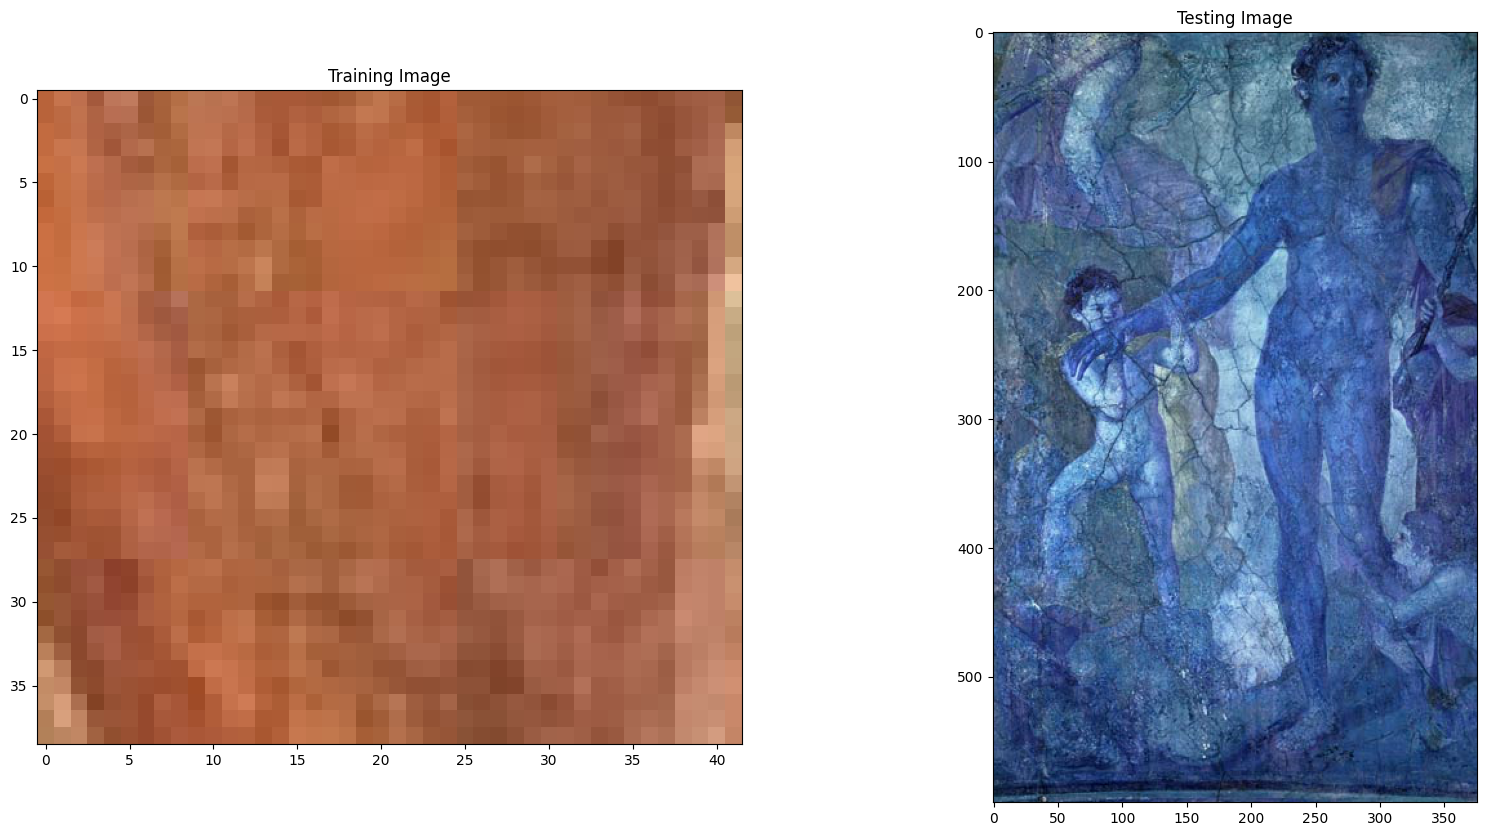

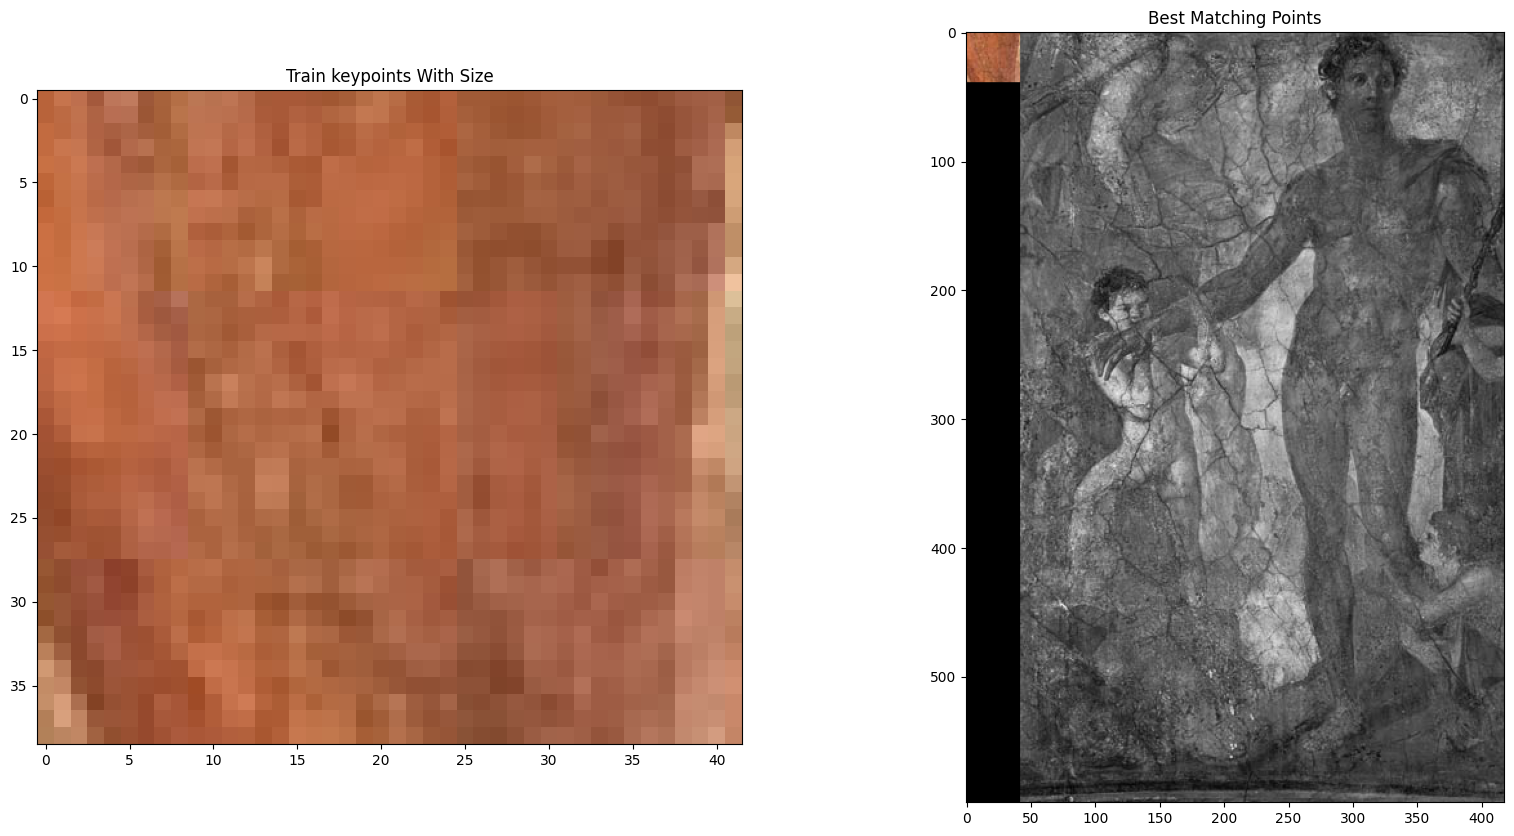


Number of Matching Keypoints Between The Training and Query Images:  0


In [65]:
# Import resources and display image

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image1 = cv.imread("./data/5.33.28.png", cv.IMREAD_UNCHANGED)

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = reference_images[0]
num_rows, num_cols = test_image.shape[:2]

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)


# ## Detect keypoints and Create Descriptor

sift = cv2.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))


# ## Matching Keypoints


# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)
good_matches = [match for match in matches if match.distance  < 2500]

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))


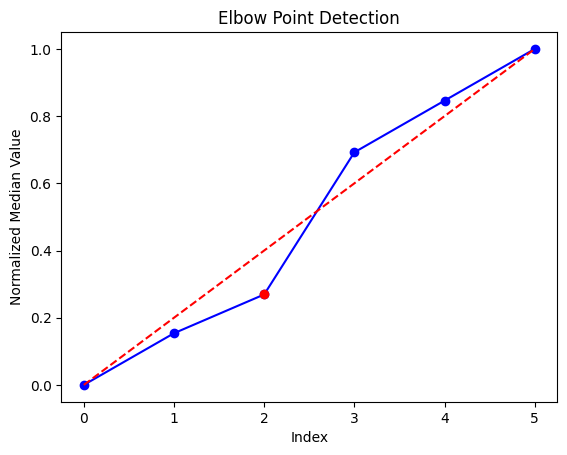

{'fragment5': 0.5, 'fragment3': 0.9, 'fragment1': 1.2}


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Sample dictionary of (key, median) values
fragments_to_refine = {
    'fragment1': 1.2,
    'fragment2': 2.3,
    'fragment3': 0.9,
    'fragment4': 3.1,
    'fragment5': 0.5,
    'fragment6': 2.7
}

# Step 1: Sort the dictionary by median values
sorted_fragments = sorted(fragments_to_refine.items(), key=lambda x: x[1])

# Extract keys and values
keys = [item[0] for item in sorted_fragments]
values = np.array([item[1] for item in sorted_fragments])

# Step 2: Normalize the values
norm_values = (values - values.min()) / (values.max() - values.min())

# Step 3: Calculate distances to the line formed by the first and last points
n_points = len(norm_values)
all_coords = np.vstack((range(n_points), norm_values)).T
line_vec = all_coords[-1] - all_coords[0]
line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
vec_from_first = all_coords - all_coords[0]
scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
vec_to_line = vec_from_first - vec_from_first_parallel
distances = np.sqrt(np.sum(vec_to_line**2, axis=1))

# Step 4: Find the elbow point
elbow_idx = np.argmax(distances)
elbow_value = values[elbow_idx]

# Select elements before the elbow point
selected_fragments = {keys[i]: values[i] for i in range(elbow_idx + 1)}

# Optional: Plot for visualization
plt.figure()
plt.plot(range(n_points), norm_values, 'b-', marker='o')
plt.plot([0, n_points - 1], [norm_values[0], norm_values[-1]], 'r--')
plt.plot(elbow_idx, norm_values[elbow_idx], 'ro')
plt.title('Elbow Point Detection')
plt.xlabel('Index')
plt.ylabel('Normalized Median Value')
plt.show()

# Output the selected fragments
print(selected_fragments)
